In [2]:
import math
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import tools

import operator
from pylab import figure, cm

N = 10218337
W  = 0.5
c1 = 0.8
c2 = 0.9 

In [48]:
filepath = "data/covid-19-data-master 16.5.22/public/data/owid-covid-data.csv"
new_cases, total_cases, total_deaths, total_vaccinations = tools.get_data(filepath, country="Sweden") #owid data starts from 1 Feb 2020
new_cases = new_cases[14:]; total_cases = total_cases[14:]; total_deaths = total_deaths[14:]; total_vaccinations = total_vaccinations[14:] #make owid data start from 15 Feb 2020

active_cases = np.array(tools.active_sweden)
compareLength = 200

def cost(x,y):
    return (x*y)**2

def rmse(list1,list2):
    return np.sqrt(np.mean((list1-list2)**2))

def generateParticlePosition(dim,bounds):
    output = []
    for i in range(dim):
        lb = bounds[i][0]
        ub = bounds[i][1]
        mid = (lb+ub)/2
        diff = (lb-ub)/2
        output.append(((-1)**bool(random.getrandbits(1))) * random.random()*diff + mid)
    return np.array(output)

def cumulative(arr):
    output = [arr[0]]
    for i in range(1,len(arr)):
        output.append(output[-1] + arr[i])
    return output

def perturb(arr,bounds):
    return []

def estimateX(t):
    return [0,0,active_cases[t],0,total_deaths[t]]

class Epicurve():
    def __init__(self,x0,theta,length=0):
        self.length = length
        self.xList = Epicurve.simulation(x0,theta,length)
    def sList(self):
        return np.array([_[0] for _ in self.xList])
    def eList(self):
        return np.array([_[1] for _ in self.xList])
    def iList(self):
        return np.array([_[2] for _ in self.xList])
    def rList(self):
        return np.array([_[3] for _ in self.xList])
    def dList(self):
        return np.array([_[4] for _ in self.xList])
    def f(x,theta):
        global N
        [s1,e1,i1,r1,d1] = x
        [beta, sigma, gamma, mu] = theta
        s2 = s1 - beta*i1*s1/N
        e2 = e1 + beta*i1*s1/N - sigma*e1
        i2 = i1 + sigma*e1 - gamma*i1 - mu*i1
        r2 = r1 + gamma*i1
        d2 = d1 + mu*i1
        return np.array([s2,e2,i2,r2,d2])
    def simulation(x0,theta,length):
        xList = np.empty((0,5))
        xList = np.append(xList,np.array([x0]),axis=0)
        x1 = x0
        for i in range(length):
            x2 = Epicurve.f(x1,theta)
            xList = np.append(xList,np.array([x2]),axis=0)
            x1 = x2
        return xList
    def peak(iList):
        return max(iList)
    def peak_time(iList):
        peak = Epicurve.peak(iList)
        for i in range(len(iList)):
            if iList[i] == peak:
                return i
        return 'error'
    
class Particle():
    #position: [start date (float), **parameters (float)...]
    #dim: number of parameters + 1, 
    def __init__(self,dim,bounds):
        if dim < 1:
            raise "dim >= 1 pls"
        self.dim = dim
        self.position = generateParticlePosition(dim,bounds)
        self.vel = np.array([0 for i in range(dim)])
        self.pbest_position = self.position
        self.pbest_value = float('inf')
    def __str__(self):
        return "I am at " + str(self.position) + " my pbest is " + str(self.pbest_position)
    def update_vel(pbest,gbest):
        global W, c1, c2
        pbest_dist = list(map(operator.sub,self.pbest_position,particle.position))
        gbest_dist = list(map(operator.sub,self.pbest_position,particle.position))

    def move(self):
        self.position = self.position + self.vel

class Space():
    def __init__(self,target,target_error,dim=0,bounds=0,n_particles=0):
        self.target = target
        self.target_error = target_error
        self.n_particles = n_particles
        self.particles = [Particle(dim,bounds) for i in range(n_particles)]
        self.gbest_value = float('inf')
        self.gbest_position = np.array([0 for i in range(dim)])
        
    def print_particles(self):
        for particle in self.particles:
            print(particle)
            
    def fitness(self, particle):
        #COST FUNCTION!!!!!!!!!
        global compareLength
        startX = [N-1,0,1,0,0]
        epicurve = Epicurve(startX,particle.position,length=compareLength)
        cost = rmse(epicurve.iList(),active_cases[:compareLength + 1])
        #print(cost)
        return cost
    
    def update_pbest(self):
        for particle in self.particles:
            fitness_candidate = self.fitness(particle)
            if(fitness_candidate < particle.pbest_value):
                particle.pbest_value = fitness_candidate
                particle.pbest_position = particle.position
    def update_gbest(self):
        for particle in self.particles:
            best_fitness_candidate = self.fitness(particle)
            if(best_fitness_candidate < self.gbest_value):
                self.gbest_value = best_fitness_candidate
                self.gbest_position = particle.position
                
    def move_particles(self):
        global W, c1, c2
        for particle in self.particles:
            #update particle velocity
            particle.vel = W*particle.vel +\
                          random.random()*c1*(particle.pbest_position - particle.position) +\
                          random.random()*c2*(self.gbest_position - particle.position)
            particle.move()
            
#space = Space(0,0,dim=2,bounds=[[-10,10],[-10,10]],n_particles=50)
#curve1 = Epicurve([N-10,0,10,0,0],[0.35,0.18,0.1,0.035],length=200)

In [71]:
active_cases = np.array(Epicurve([N-1,0,1,0,0],[0.5,0.5,0.2,0.05],length=compareLength).iList())
space = Space(0,0,dim=4,bounds=[[0.49,0.51],[0.49,0.51],[0.19,0.21],[0.045,0.055]],n_particles=75)

'''
bestParticle = Particle(4,[[0.5,0.5],[0.5,0.5],[0.2,0.2],[0.05,0.05]])
particle1 = Particle(4,[[0.501,0.501],[0.501,0.501],[0.201,0.201],[0.0501,0.0501]])
plt.plot(Epicurve([N-1,0,1,0,0],particle1.position,length=compareLength).iList())
plt.plot(active_cases[:len(optimal_iList)+1])
print(space.fitness(bestParticle))
print(space.fitness(particle1))
'''

'''
space = Space(0,0,dim=4,bounds=[[0,0.8],[0.05,0.3],[0.05,0.15],[0.02,0.04]],n_particles=50)
#space.print_particles()
plt.plot(cumulative(new_cases))
plt.plot(active_cases)

print(len(new_cases),len(active_cases))
'''


def optimize(space,n_iterations):
    for i in range(n_iterations):
        space.update_pbest()
        space.update_gbest()
        space.move_particles()

n_iterations = 150
optimize(space,n_iterations)
print("The best solution is: ", space.gbest_position, " in n_iterations: ", n_iterations)


The best solution is:  [0.49786305 0.50671857 0.19703585 0.05249475]  in n_iterations:  150


[0.49786305 0.50671857 0.19703585 0.05249475]
133.53172968577726
3887.554203781037


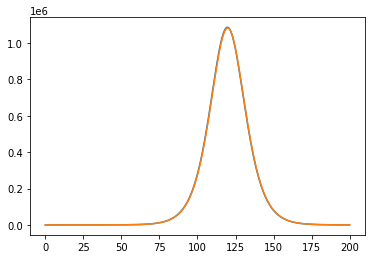

In [79]:
optimalCurve = Epicurve([N-10,0,10,0,0],space.gbest_position,length=compareLength)
optimalParticle = Particle(4,[[space.gbest_position[0],space.gbest_position[0]],
                              [space.gbest_position[1],space.gbest_position[1]],
                              [space.gbest_position[2],space.gbest_position[2]],
                              [space.gbest_position[3],space.gbest_position[3]]])
print(space.gbest_position)
print(space.fitness(optimalParticle))
#print(list(map(operator.sub,l1,l2)))
optimal_iList = optimalCurve.iList()

'''
#visualise determined best theta and actual theta graphs
plt.plot(optimal_iList)
plt.plot(active_cases[:len(optimal_iList)+1])
plt.show()
'''

#visualising how much the graph changes with small change in theta
plt.plot(Epicurve([N-1,0,1,0,0],[0.497,0.51,0.197,0.052],length=compareLength).iList())
plt.plot(active_cases[:len(optimal_iList)+1])
print(rmse(Epicurve([N-1,0,1,0,0],[0.497,0.51,0.197,0.052],length=compareLength).iList(),active_cases[:len(optimal_iList)+1]))